In [1]:
import pandas as pd 
import numpy as np 
df1=pd.read_csv('./archive/tmdb_5000_credits.csv')
df2=pd.read_csv('./archive/tmdb_5000_movies.csv')

In [2]:
df1.columns= df1.columns.str.strip()
df2.columns=df2.columns.str.strip()

df1.columns = ['movie_id', 'title', 'cast', 'crew']
movies= df2.merge(df1,left_on='id', right_on='movie_id')

In [3]:
ratings = pd.read_csv('./Movies_dataset/ratings_small.csv')
# Display first few rows of ratings dataset
print(ratings.head())

   userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205


In [4]:
# Check for missing values
print("Missing values in ratings:", ratings.isnull().sum())
print("Missing values in movies:", movies.isnull().sum())

Missing values in ratings: userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
Missing values in movies: budget                  0
genres                  0
homepage                0
id                      0
keywords                0
original_language       0
original_title          0
overview                0
popularity              0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
tagline                 0
title_x                 0
vote_average            0
vote_count              0
movie_id                0
title_y                 0
cast                    0
crew                    0
dtype: int64


In [5]:
# Drop any rows with missing values if necessary
ratings.dropna(inplace=True)
movies.dropna(inplace=True)

In [6]:
# # Convert 'userId' and 'movieId' to categorical codes for embedding layers
ratings['userId'] = ratings['userId'].astype('category').cat.codes
ratings['movieId'] = ratings['movieId'].astype('category').cat.codes

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns


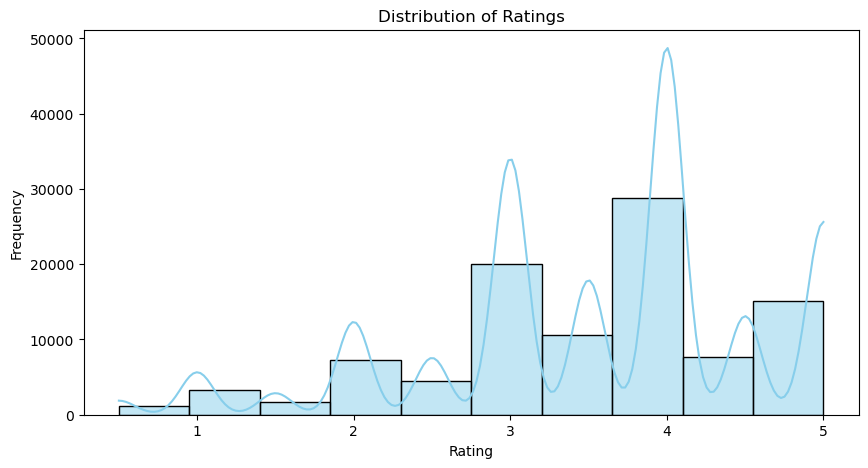

In [8]:
# Plot distribution of ratings
plt.figure(figsize=(10, 5))
sns.histplot(ratings['rating'], bins=10, kde=True, color='skyblue')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

In [9]:
print(ratings.columns)

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


In [10]:
# Merge ratings and movies on 'movieId' to access titles
ratings_with_titles = ratings.merge(movies, left_on='movieId', right_on='movie_id', how='left')


In [11]:
top_movies = ratings_with_titles['original_title'].value_counts().head(10)

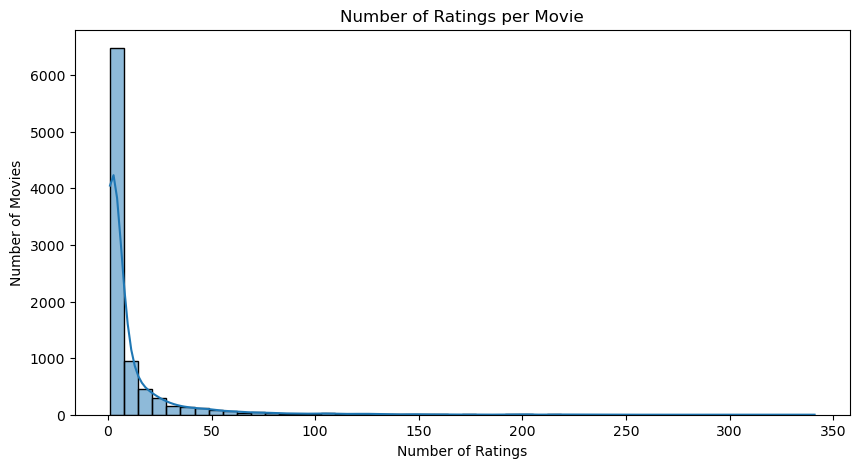

In [12]:
# Number of ratings per movie
movie_counts = ratings['movieId'].value_counts()
plt.figure(figsize=(10, 5))
sns.histplot(movie_counts, bins=50, kde=True)
plt.title("Number of Ratings per Movie")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Movies")
plt.show()

In [13]:
print(movies.columns)

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title_x', 'vote_average',
       'vote_count', 'movie_id', 'title_y', 'cast', 'crew'],
      dtype='object')


/var/folders/7z/kfcjh8xj1wbc9dktydd14w540000gn/T/ipykernel_9056/3222318350.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_movies.index, y=top_movies.values, palette='viridis')


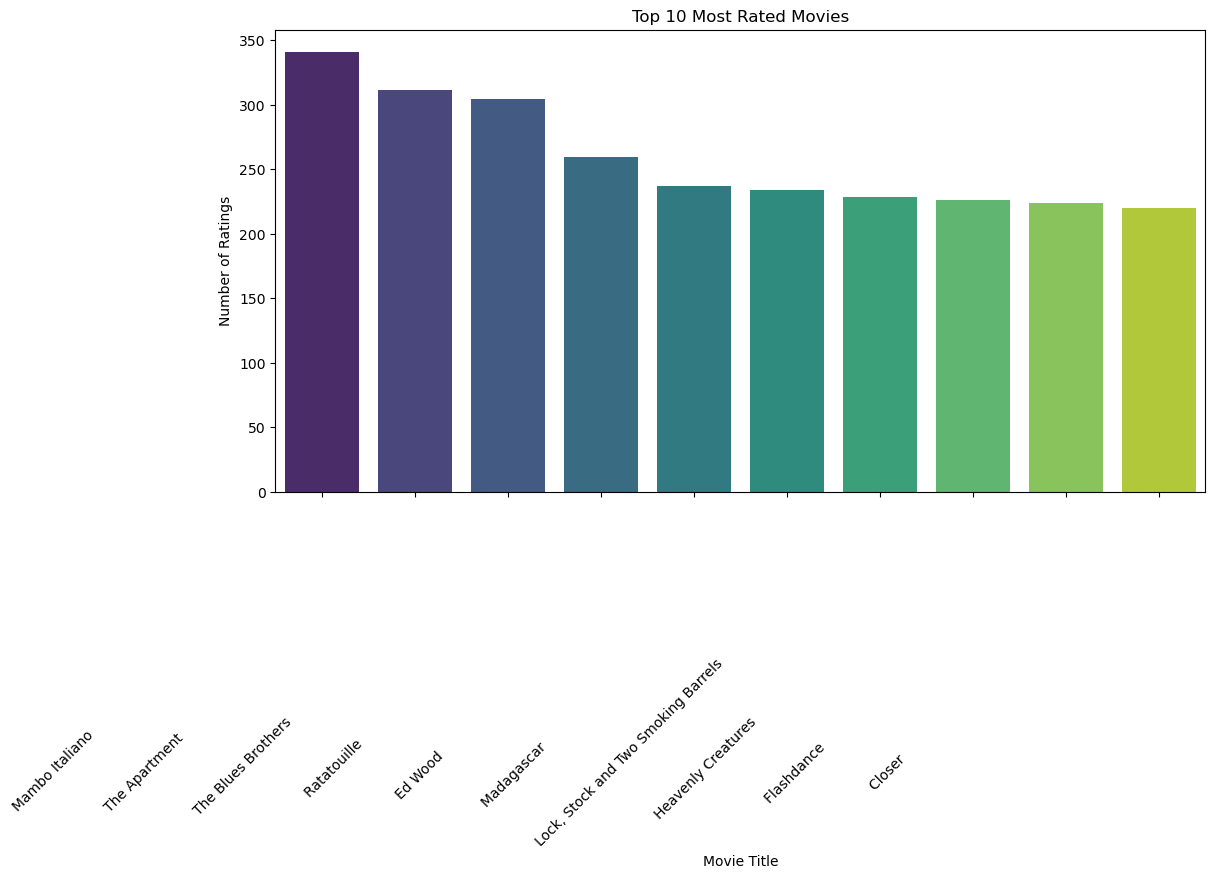

In [14]:
# Plot top 10 most rated movies
plt.figure(figsize=(12, 6))
sns.barplot(x=top_movies.index, y=top_movies.values, palette='viridis')
plt.title("Top 10 Most Rated Movies")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Movie Title")
plt.ylabel("Number of Ratings")
plt.show()

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [16]:
# Check if M1 GPU is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [17]:
# Define Dataset class
class RatingsDataset(Dataset):
    def __init__(self, ratings_df):
        self.user_ids = torch.tensor(ratings_df['userId'].values, dtype=torch.long)
        self.movie_ids = torch.tensor(ratings_df['movieId'].values, dtype=torch.long)
        self.ratings = torch.tensor(ratings_df['rating'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.user_ids[idx], self.movie_ids[idx], self.ratings[idx]


In [18]:
# Instantiate Dataset and DataLoader
dataset = RatingsDataset(ratings)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [19]:
# Define Recommender Model
class RecommenderNet(nn.Module):
    def __init__(self, n_users, n_movies, embedding_size=50):
        super(RecommenderNet, self).__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_size)
        self.movie_embedding = nn.Embedding(n_movies, embedding_size)
        self.fc1 = nn.Linear(embedding_size * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, user_id, movie_id):
        user_vector = self.user_embedding(user_id)
        movie_vector = self.movie_embedding(movie_id)
        x = torch.cat([user_vector, movie_vector], dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x).squeeze()

In [20]:
# Initialize model and move it to the device (M1 GPU if available)
n_users = ratings['userId'].nunique()
n_movies = ratings['movieId'].nunique()
model = RecommenderNet(n_users, n_movies, embedding_size=50).to(device)

In [21]:
# Set up loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
# Training loop
n_epochs = 500
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for user_ids, movie_ids, ratings in dataloader:
        # Move data to device
        user_ids, movie_ids, ratings = user_ids.to(device), movie_ids.to(device), ratings.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(user_ids, movie_ids)
        loss = criterion(outputs, ratings)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    if epoch%10==0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/500], Loss: 1.0443
Epoch [11/500], Loss: 0.5272
Epoch [21/500], Loss: 0.2891
Epoch [31/500], Loss: 0.1858
Epoch [41/500], Loss: 0.1352
Epoch [51/500], Loss: 0.1058
Epoch [61/500], Loss: 0.0879
Epoch [71/500], Loss: 0.0739
Epoch [81/500], Loss: 0.0647
Epoch [91/500], Loss: 0.0575
Epoch [101/500], Loss: 0.0521
Epoch [111/500], Loss: 0.0480
Epoch [121/500], Loss: 0.0446
Epoch [131/500], Loss: 0.0419
Epoch [141/500], Loss: 0.0393
Epoch [151/500], Loss: 0.0368
Epoch [161/500], Loss: 0.0355
Epoch [171/500], Loss: 0.0338
Epoch [181/500], Loss: 0.0328
Epoch [191/500], Loss: 0.0316
Epoch [201/500], Loss: 0.0305
Epoch [211/500], Loss: 0.0294
Epoch [221/500], Loss: 0.0289
Epoch [231/500], Loss: 0.0280
Epoch [241/500], Loss: 0.0272
Epoch [251/500], Loss: 0.0267
Epoch [261/500], Loss: 0.0261
Epoch [271/500], Loss: 0.0257
Epoch [281/500], Loss: 0.0250
Epoch [291/500], Loss: 0.0247
Epoch [301/500], Loss: 0.0243
Epoch [311/500], Loss: 0.0239
Epoch [321/500], Loss: 0.0233
Epoch [331/500], Loss

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [25]:
# Split ratings data into training and validation sets
train_data, val_data = train_test_split(ratings, test_size=0.2, random_state=42)



In [26]:
# Function to evaluate the model
def evaluate_model(model, val_dataloader):
    model.eval()
    predictions, actuals = [], []
    
    with torch.no_grad():
        for user_ids, movie_ids, ratings in val_dataloader:
            user_ids, movie_ids, ratings = user_ids.to(device), movie_ids.to(device), ratings.to(device)
            outputs = model(user_ids, movie_ids)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(ratings.cpu().numpy())
    
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    return rmse, mae


In [27]:
# Evaluate the model and print RMSE and MAE
rmse, mae = evaluate_model(model, dataloader)
print(f"Validation RMSE: {rmse:.4f}")
print(f"Validation MAE: {mae:.4f}")

Validation RMSE: 0.1322
Validation MAE: 0.0969


In [28]:
print(type(val_data))

<class 'torch.Tensor'>


In [62]:
import torch

# Ensure the model runs on the correct device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

def predict_rating(user_id, movie_id):
    """
    Predict the rating for a given user and movie.
    """
    # Convert inputs to tensors and move to the appropriate device
    user_tensor = torch.tensor([user_id], dtype=torch.long).to(device)
    movie_tensor = torch.tensor([movie_id], dtype=torch.long).to(device)
    
    # Set model to evaluation mode
    model.eval()
    
    # Disable gradient calculation for inference
    with torch.no_grad():
        # Get the prediction
        predicted_rating = model(user_tensor, movie_tensor).item()
    
    return predicted_rating

# Example usage: Predict rating for a specific user and movie
user_id = 1  # Replace with desired user ID
movie_id = 55  # Replace with desired movie ID
predicted_rating = predict_rating(user_id, movie_id)

print(f"Predicted Rating for User ID {user_id} and Movie ID {movie_id}: {predicted_rating:.2f}")


Predicted Rating for User ID 1 and Movie ID 55: 3.50


In [63]:
# Save the trained model to a file
torch.save(model.state_dict(), 'movie_rating_model.pth')
print("Model saved successfully.")


Model saved successfully.


In [64]:
model.load_state_dict(torch.load('movie_rating_model.pth'))
model.eval()  # Make sure to set it to evaluation mode before inference


/var/folders/7z/kfcjh8xj1wbc9dktydd14w540000gn/T/ipykernel_9056/2743987003.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('movie_rating

RecommenderNet(
  (user_embedding): Embedding(671, 50)
  (movie_embedding): Embedding(9066, 50)
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)